In [235]:
import math, os, torchvision, torch, glob
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, datasets
import torch.nn.functional as F
from PIL import Image

> Modificamos el train

In [254]:
root_dir = '/home/chino/VSProjects/Proyecto4/Propuesta/images/'
csv_file = '/home/chino/VSProjects/Proyecto4/Propuesta/train.csv'
csv = pd.read_csv(csv_file)

csv[['numero1', 'numero2']] = csv['image1_image2'].str.split('_', expand=True)
csv['label_num'] = csv['label'].apply(lambda x: 1 if x == 'same' else 0)
csv = csv.drop(columns=["image1_image2", "label"])

csv_invertido = csv[['numero2', 'numero1', 'label_num']].copy()
csv_invertido.columns = ['numero1', 'numero2', 'label_num']

csv = pd.concat([csv, csv_invertido], ignore_index=True)

> Example img transformed


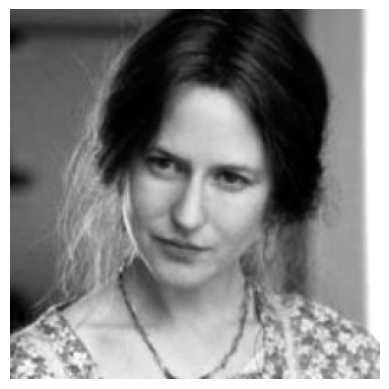

In [255]:
image_path = '/home/chino/VSProjects/Proyecto4/Propuesta/images/313.png'
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transformed_image = transform(image)
transformed_image_np = transformed_image.numpy().transpose((1, 2, 0))
transformed_image_np = transformed_image_np * 0.5 + 0.5

plt.imshow(transformed_image_np.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

> Creamos el train loader 

In [256]:

transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Definir el Dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img1_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 0]) + '.png')
        img2_name = os.path.join(self.root_dir, str(self.dataframe.iloc[idx, 1]) + '.png')
        label = self.dataframe.iloc[idx, 2]

        img1 = Image.open(img1_name).convert('RGB')
        img2 = Image.open(img2_name).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        #return img1, img2, torch.tensor([label], dtype=torch.float32)
        return img1, img2, torch.tensor(label, dtype=torch.float32)


dataset = CustomImageDataset(dataframe=csv, root_dir=root_dir, transform=transform)
batch_size = 16
train_len = 0.8
train_dataset, test_dataset = random_split(dataset, [train_len, (1-train_len)], generator=torch.Generator().manual_seed(10))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [257]:
for batch_idx, (img1, img2, label) in enumerate(train_dataloader):
    print(f"Batch train {batch_idx}: img1 shape {img1.shape}, img2 shape {img2.shape}, label shape {label.shape}")
print("Test loading")
for batch_idx, (img1, img2, label) in enumerate(test_dataloader):
    print(f"Batch test {batch_idx}: img1 shape {img1.shape}, img2 shape {img2.shape}, label shape {label.shape}")

Batch train 0: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 1: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 2: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 3: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 4: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 5: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 6: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label shape torch.Size([16])
Batch train 7: img1 shape torch.Size([16, 1, 256, 256]), img2 shape torch.Size([16, 1, 256, 256]), label

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Modelo:

In [97]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [240]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64*5*5, 1024)
        self.dropout_fc1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout_fc2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)

    def forward_once(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.layer2(out)
        out = self.bn2(out)
        out = self.layer3(out)
        out = self.bn3(out)
        out = self.layer4(out)
        out = self.bn4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.dropout_fc1(out)
        out = self.fc2(out)
        out = self.dropout_fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out
        
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2




### Training

In [290]:
def train(model, train_loader, Epochs, loss_fn, optimizer, scheduler):
    train_loss = []
    train_time = []
    medium_loss = []
    for epoch in range(Epochs):
        model.train()
        med_loss= 0
        counter = 0

        # Ejemplo de iteración sobre el DataLoader
        for batch_idx, (img1, img2, label) in enumerate(train_loader):

            image1 = img1.to(device)
            image2 = img2.to(device)
            label = label.to(device)
            output1, output2 = model(image1,image2)
             
            #Using BCEWithLogisticLoss
            loss = loss_fn(F.pairwise_distance(output1, output2), label)

            #Using ContrastiveLoss
            #Using CosineDistance
            #loss = loss_fn(output1, output2, label)

            #print(output1)
            #print(output2)
            #print(label)

            #los_fn_alt = nn.CosineEmbeddingLoss(margin=0.5)
            #loss_alt = los_fn_alt(output1,output2, label)
            #print(loss_alt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            med_loss+=abs(loss.item())
            counter+=1
            train_loss.append(loss.item())
            train_time.append(batch_idx)
            if (batch_idx + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch + 1, Epochs, batch_idx + 1, len(train_loader), loss.item()))

                #print(f"Batch {batch_idx}: img1 shape {img1.shape}, img2 shape {img2.shape}, label shape {label.shape}")
        medium_loss.append(med_loss/counter)
        #scheduler.step()
    
    print('Finished Training Trainset')
    return train_loss, train_time, medium_loss

            



In [295]:
siamese_nn = SiameseNetwork()
optimizer = torch.optim.Adam(params=siamese_nn.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = ContrastiveLoss()
#loss_fn = nn.HingeEmbeddingLoss(margin=1.0)
#loss_fn = nn.CosineEmbeddingLoss(margin=0.5)

epochs = 30              

            
model = siamese_nn.to(device)

loss_result, time_result, medium_loss = train(model, train_dataloader, epochs, loss_fn, optimizer, scheduler)


Epoch [1/30], Step [5/221], Loss: 0.910009503364563
Epoch [1/30], Step [10/221], Loss: 0.7593824863433838
Epoch [1/30], Step [15/221], Loss: 0.6421459913253784
Epoch [1/30], Step [20/221], Loss: 0.7583281993865967
Epoch [1/30], Step [25/221], Loss: 0.6315529346466064
Epoch [1/30], Step [30/221], Loss: 0.688163697719574
Epoch [1/30], Step [35/221], Loss: 0.7394553422927856
Epoch [1/30], Step [40/221], Loss: 0.7879948616027832
Epoch [1/30], Step [45/221], Loss: 0.7049287557601929
Epoch [1/30], Step [50/221], Loss: 0.8120829463005066
Epoch [1/30], Step [55/221], Loss: 0.6985166668891907
Epoch [1/30], Step [60/221], Loss: 0.7535136938095093
Epoch [1/30], Step [65/221], Loss: 0.7092630863189697
Epoch [1/30], Step [70/221], Loss: 0.7702416181564331
Epoch [1/30], Step [75/221], Loss: 0.7070494890213013
Epoch [1/30], Step [80/221], Loss: 0.7667544484138489
Epoch [1/30], Step [85/221], Loss: 0.8899986147880554
Epoch [1/30], Step [90/221], Loss: 0.789679765701294
Epoch [1/30], Step [95/221], Los

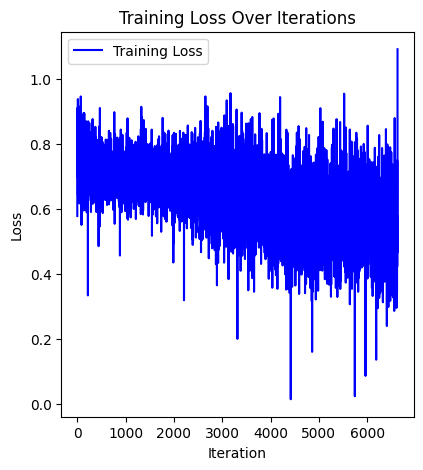

In [296]:
# Plot the loss function    
plt.figure(figsize=(10, 5))

# Plot the loss 
plt.subplot(1, 2, 1)
plt.plot(loss_result, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

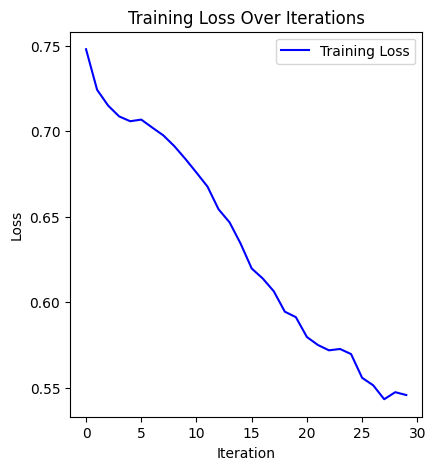

In [297]:
# Plot the loss function
plt.figure(figsize=(10, 5))
    
# Plot the los                                          s
plt.subplot(1, 2, 1)
plt.plot(medium_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

> Testing

In [298]:
def test(model, test_loader, threshold=0.5):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, (img1, img2, labels) in enumerate(test_loader):
            image1 = img1.to(device)
            image2 = img2.to(device)
            labels = labels.to(device)

            output1, output2 = model(image1, image2)
            
            # Calcular la similitud del coseno
            #cosine_similarity = nn.functional.cosine_similarity(output1, output2)
            cosine_similarity = F.pairwise_distance(output1, output2)

            
            # Convertir la similitud del coseno a predicciones (1 si similares, 0 si no)
            #predictions = torch.where(cosine_similarity > threshold, torch.tensor(1.0), torch.tensor(-1.0))
            predictions = torch.where(cosine_similarity > threshold, torch.tensor(1.0), torch.tensor(0.0))

            #print("Cosine:  :",cosine_similarity)
            #print("Prediccion:  :", predictions.item())
            #print("True Label:  :", labels.item())
            #print("State:   : ", (predictions == labels).sum().item())

            #print("\n")
            #if (idx == 15): return 0,0,0
            
            total += 1
            correct += (predictions == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy, correct, total

In [299]:
test_accuracy, correct, total = test(model, test_dataloader)
    
print("\nTest Accuracy:  ", test_accuracy)
print("Correct:  ", correct)
print("Total:  ", total)


Test Accuracy:   75.31285551763368
Correct:   662
Total:   879


In [300]:
torch.save(model, 'ModelBCE30.pth') 